The purpose of this file is to only create visual representation of the existing data for the thesis. No additional data is being created.

In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import pairwise_distances
import requests
from datetime import datetime, timedelta, timezone
from urllib.parse import urlparse
from tqdm import tqdm
from dateutil.relativedelta import relativedelta
from pydriller.repository import Repository
import matplotlib.pyplot as plt
import seaborn as sns
import math
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
import seaborn as sns
import glob

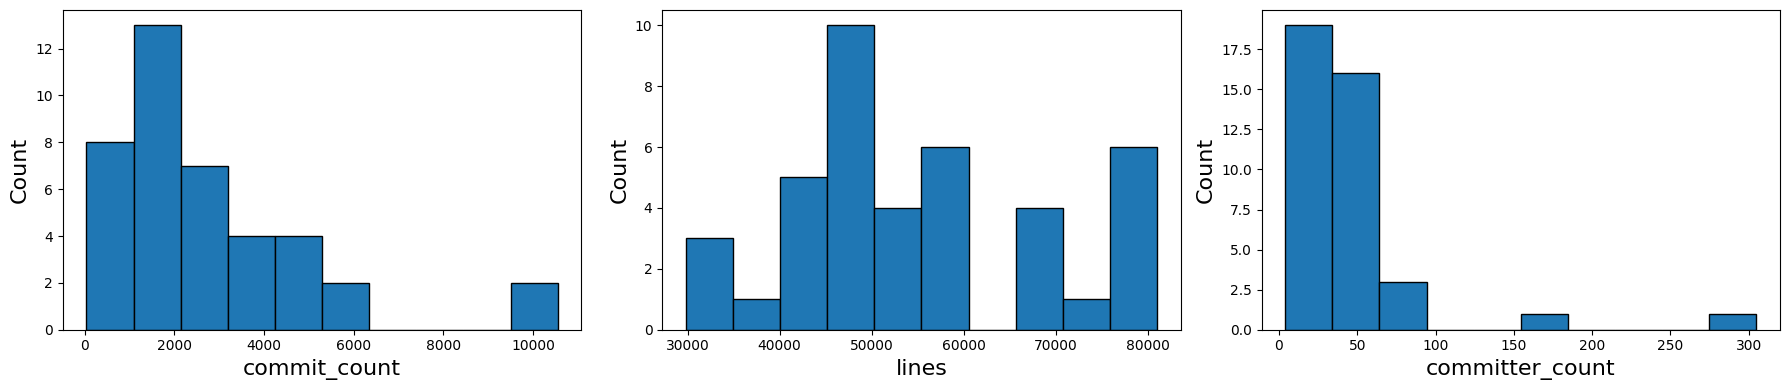

In [15]:
old_set = pd.read_csv('average_projects.csv')
new_set = pd.read_csv('average_projects_update.csv')

selected_columns = [
    'commit_count',
    'lines',
    'committer_count'
]

# make two seperate graphs

n = len(selected_columns)

cols_per_row = 3
rows = math.ceil(n / cols_per_row)

fig, axes = plt.subplots(rows, cols_per_row, figsize=(6 * cols_per_row, 4 * rows))
axes = axes.flatten()

for i, col in enumerate(selected_columns):
    axes[i].hist(old_set[col], bins=10, edgecolor='black')
    axes[i].set_xlabel(col, fontsize=16)
    axes[i].set_ylabel("Count", fontsize=16)

for j in range(n, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

# fig, axes = plt.subplots(rows, cols_per_row, figsize=(6 * cols_per_row, 4 * rows))
# axes = axes.flatten()

# for i, col in enumerate(selected_columns):
#     axes[i].hist(new_set[col], bins=10, edgecolor='black')
#     axes[i].set_xlabel(col, fontsize=16)
#     axes[i].set_ylabel("Count", fontsize=16)

# for j in range(n, len(axes)):
#     fig.delaxes(axes[j])

# plt.tight_layout()
# plt.show()

Trend differences of different time intervals on graph

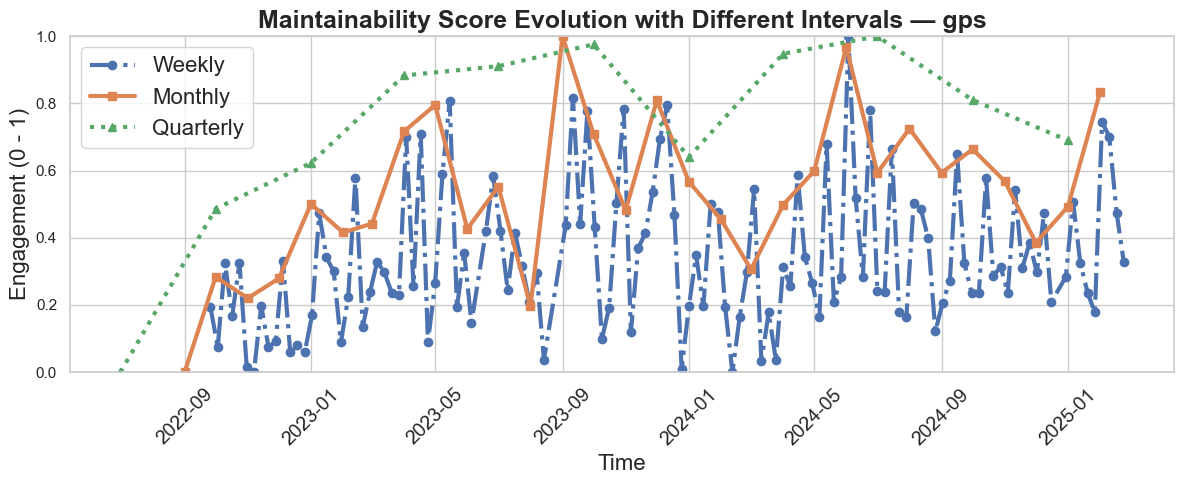

In [6]:
df = pd.read_csv('commit_data_active.csv', parse_dates=['commit_date'])

df = df.sort_values(['url', 'developer', 'commit_date'])
df['time_since_last_hours'] = (
    df.groupby(['url','developer'])['commit_date']
      .diff()
      .dt.total_seconds()
      .div(3600)
).fillna(0)

def compute_engagement(df, freq):
    tmp = df.copy()
    tmp['period'] = tmp['commit_date'].dt.to_period(freq).dt.to_timestamp()
    agg = tmp.groupby(['url','period']).agg(
        churn_sum          = ('churn',                 'sum'),
        commit_count       = ('commit_date',           'count'),
        dev_count          = ('developer',             'nunique'),
        avg_interval_hours = ('time_since_last_hours', 'mean')
    ).reset_index()
    agg['churn_per_dev'] = agg['churn_sum'] / agg['dev_count'].replace(0,1)
    feats = ['churn_sum','commit_count','dev_count','avg_interval_hours','churn_per_dev']
    X = StandardScaler().fit_transform(agg[feats])
    agg['eng_raw'] = PCA(n_components=1).fit_transform(X).ravel()
    def mm(x):
        mn, mx = x.min(), x.max()
        return (x-mn)/(mx-mn) if mx>mn else 0.0
    agg['engagement'] = agg.groupby('url')['eng_raw'].transform(mm)
    return agg[['url','period','engagement']]

eng_weekly  = compute_engagement(df, 'W')
eng_monthly = compute_engagement(df, 'M')
eng_quarter = compute_engagement(df, 'Q')

for project in df['url'].unique():
    w = eng_weekly [eng_weekly ['url']==project]
    m = eng_monthly[eng_monthly['url']==project]
    q = eng_quarter[eng_quarter['url']==project]
    if w.empty and m.empty and q.empty:
        continue

    plt.figure(figsize=(12, 5))
    if not w.empty:
        plt.plot(w['period'], w['engagement'],
                 marker='o', linestyle='-.', linewidth=3, markersize=6, label='Weekly')
    if not m.empty:
        plt.plot(m['period'], m['engagement'],
                 marker='s', linestyle='-', linewidth=3, markersize=6, label='Monthly')
    if not q.empty:
        plt.plot(q['period'], q['engagement'],
                 marker='^', linestyle=':', linewidth=3, markersize=6, label='Quarterly')
    
    repo_name = urlparse(project).path.split('/')[-1]

    plt.title(f'Maintainability Score Evolution with Different Intervals — {repo_name}', fontsize=18, fontweight='bold')
    plt.xlabel('Time', fontsize=16)
    plt.ylabel('Engagement (0 - 1)', fontsize=16)
    plt.ylim(0, 1)
    plt.xticks(rotation=45, fontsize=14)
    plt.legend(fontsize=16)
    plt.tight_layout()
    plt.show()
    break #comment this line to view all the projects


Engagement distribution

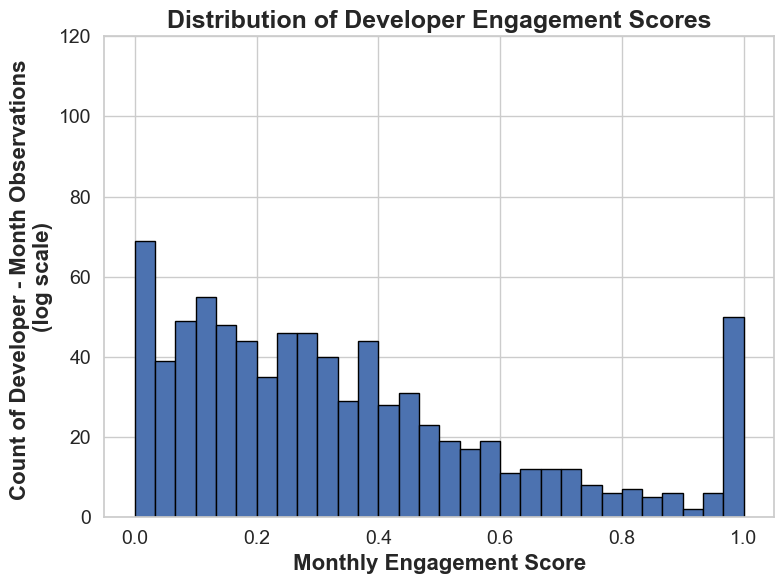

In [22]:
df = pd.read_csv('engagement_score_average.csv', parse_dates=['month']) # swap with engagement_score_average.csv for other set

plt.figure(figsize=(8, 6))
plt.hist(df['engagement_score'], bins=30, edgecolor='black')
plt.title('Distribution of Developer Engagement Scores', fontsize=18, fontweight='bold')
plt.xlabel('Monthly Engagement Score', fontsize=16, fontweight='bold')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylim(0, 120)
plt.ylabel('Count of Developer - Month Observations \n(log scale)', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

last90 visualization

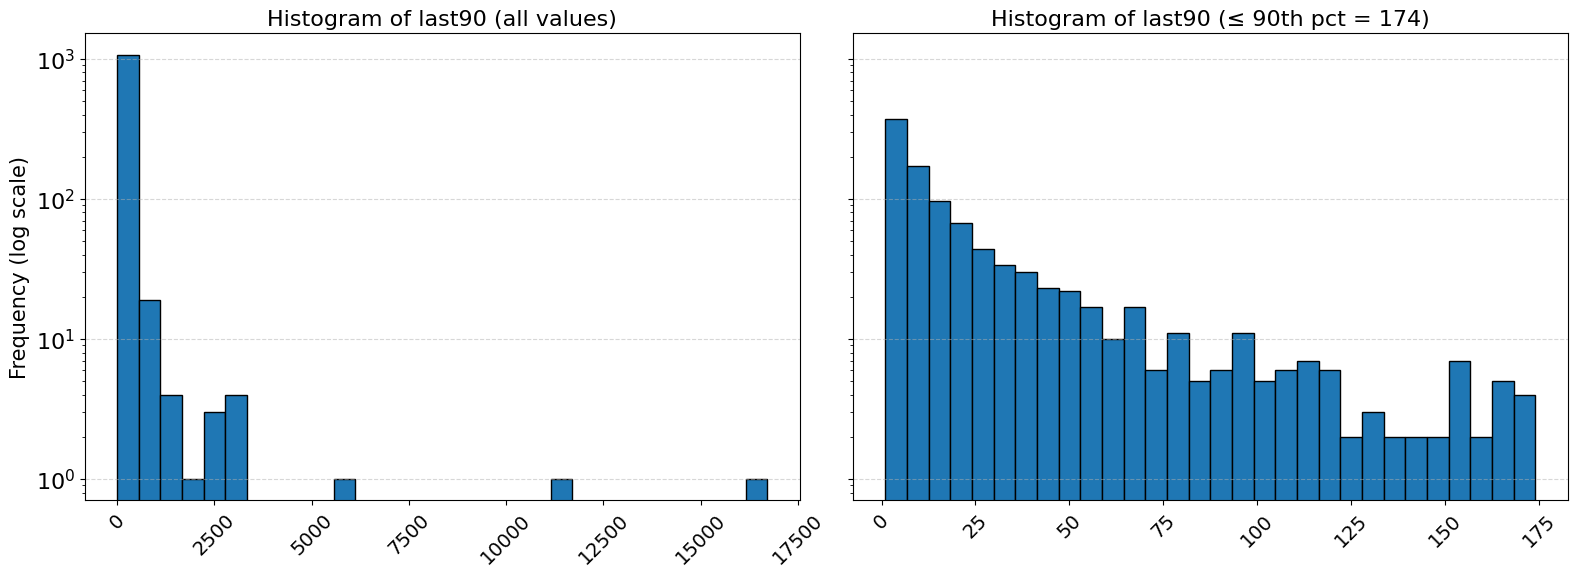

In [ ]:
df = pd.read_csv('17k_active_90days.csv')

data = df['last90'].dropna()

p90 = data.quantile(0.90)

all_vals = data
p90_vals = data[data <= p90]

plt.rcParams.update({
    'font.size': 14,
    'axes.titlesize': 16,
    'axes.labelsize': 15,
    'xtick.labelsize': 13,
    'ytick.labelsize': 13
})

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

ax1.hist(all_vals, bins=30, edgecolor='black', log=True)
ax1.set_title('Histogram of last90 (all values)')
ax1.set_ylabel('Frequency (log scale)')
ax1.grid(axis='y', linestyle='--', alpha=0.5)

for lbl in ax1.get_xticklabels():
    lbl.set_rotation(45)
    lbl.set_fontsize(14)
for lbl in ax1.get_yticklabels():
    lbl.set_fontsize(16)

ax2.hist(p90_vals, bins=30, edgecolor='black', log=True)
ax2.set_title(f'Histogram of last90 (≤ 90th pct = {int(p90)})')
ax2.grid(axis='y', linestyle='--', alpha=0.5)

for lbl in ax2.get_xticklabels():
    lbl.set_rotation(45)
    lbl.set_fontsize(14)

plt.tight_layout()
plt.show()


DMM Histograms

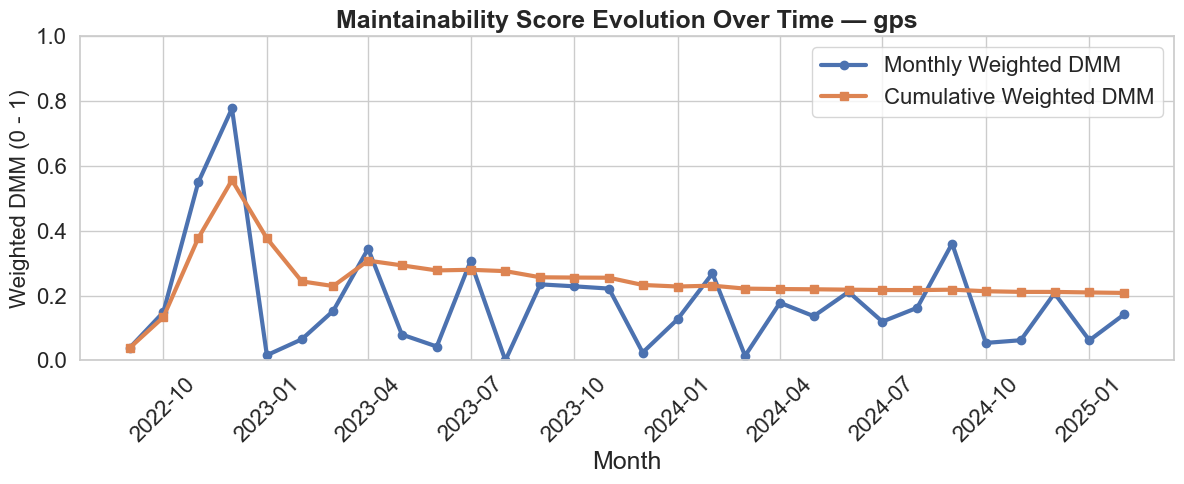

In [5]:
sns.set_theme(style="whitegrid")

monthly = pd.read_csv(
    'dmm_active.csv',
    parse_dates=['month']
)

for repo in monthly['url'].unique():
    proj_df = monthly[monthly['url'] == repo].sort_values('month')
    if proj_df.empty:
        continue

    repo_name = repo.split('/')[-1]

    plt.figure(figsize=(12, 5))
    plt.plot(
        proj_df['month'], proj_df['dmm_monthly_w'],
        marker='o', linewidth=3, label='Monthly Weighted DMM'
    )

    plt.plot(
        proj_df['month'], proj_df['dmm_cumulative_w'],
        marker='s', linewidth=3, label='Cumulative Weighted DMM'
    )
    
    plt.ylim(0.0, 1.0)
    plt.title(f'Maintainability Score Evolution Over Time — {repo_name}', fontsize=18, fontweight='bold')
    plt.xlabel('Month', fontsize=18)
    plt.ylabel('Weighted DMM (0 - 1)', fontsize=16)
    plt.xticks(rotation=45, fontsize=16)
    plt.yticks(fontsize=16)
    plt.legend(fontsize=16, loc='best')
    plt.tight_layout()
    plt.show()
    break # comment this line to view all the projects


DMM Volatility

/var/folders/b5/z76chyqn7t76g862dm6fp3bw0000gn/T/ipykernel_32016/2720489127.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="set", y="volatility", data=vol, palette=["C1","C0"])


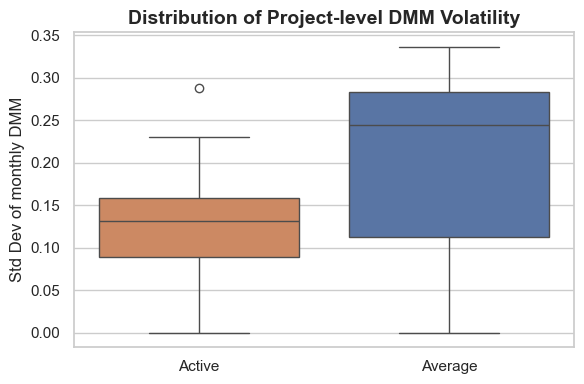

In [7]:
sns.set_theme(style="whitegrid")

def load_and_label(path, label):
    df = pd.read_csv(path, parse_dates=["month"])
    vol = ( df
           .groupby("url")["dmm_monthly_w"]
           .std()
           .reset_index(name="volatility") )
    vol["set"] = label
    return vol

vol_active  = load_and_label("dmm_active.csv",  "Active")
vol_average = load_and_label("dmm_average.csv","Average")

vol = pd.concat([vol_active, vol_average], ignore_index=True)

plt.figure(figsize=(6,4))
sns.boxplot(x="set", y="volatility", data=vol, palette=["C1","C0"])
plt.title("Distribution of Project-level DMM Volatility", fontsize=14, fontweight='bold')
plt.xlabel("")
plt.ylabel("Std Dev of monthly DMM", fontsize=12)
plt.tight_layout()
plt.show()


DMM distribution

/var/folders/9b/xhp09f3d7xn_fpzfk4sg3pj80000gn/T/ipykernel_60734/1571332787.py:34: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  all_proj


<Figure size 800x600 with 0 Axes>

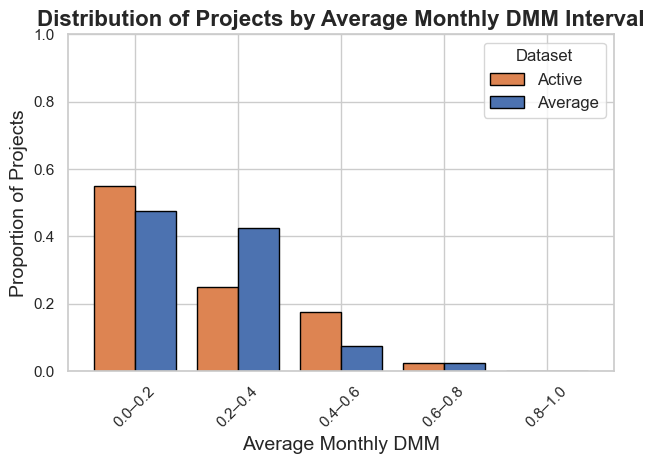

In [ ]:
df_avg = pd.read_csv('dmm_average.csv', parse_dates=['month'])
df_act = pd.read_csv('dmm_active.csv',  parse_dates=['month'])

avg_proj = (
    df_avg
    .groupby('url')['dmm_monthly_w']
    .mean()
    .reset_index(name='avg_dmm')
    .assign(set='Average')
)
act_proj = (
    df_act
    .groupby('url')['dmm_monthly_w']
    .mean()
    .reset_index(name='avg_dmm')
    .assign(set='Active')
)

all_proj = pd.concat([avg_proj, act_proj], ignore_index=True)
bins = np.linspace(0, 1, 6)
labels = [f'{bins[i]:.1f} - {bins[i+1]:.1f}' for i in range(len(bins)-1)]
all_proj['dmm_bin'] = pd.cut(all_proj['avg_dmm'], bins=bins, labels=labels, include_lowest=True)

prop = (
    all_proj
    .groupby(['set','dmm_bin'])
    .size()
    .reset_index(name='count')
)
total = prop.groupby('set')['count'].transform('sum')
prop['proportion'] = prop['count'] / total

sns.set_theme(style="whitegrid")
plt.figure(figsize=(8,6))

pt = prop.pivot(index='dmm_bin', columns='set', values='proportion').fillna(0)

pt.plot(
    kind='bar',
    width=0.8,
    color=['C1','C0'],
    edgecolor='black'
)

plt.title('Distribution of Projects by Average Monthly DMM Interval', fontsize=16, fontweight='bold')
plt.xlabel('Average Monthly DMM', fontsize=14)
plt.ylabel('Proportion of Projects', fontsize=14)
plt.xticks(rotation=45)
plt.ylim(0, 1)
plt.legend(title='Dataset', fontsize=12)
plt.tight_layout()
plt.show()


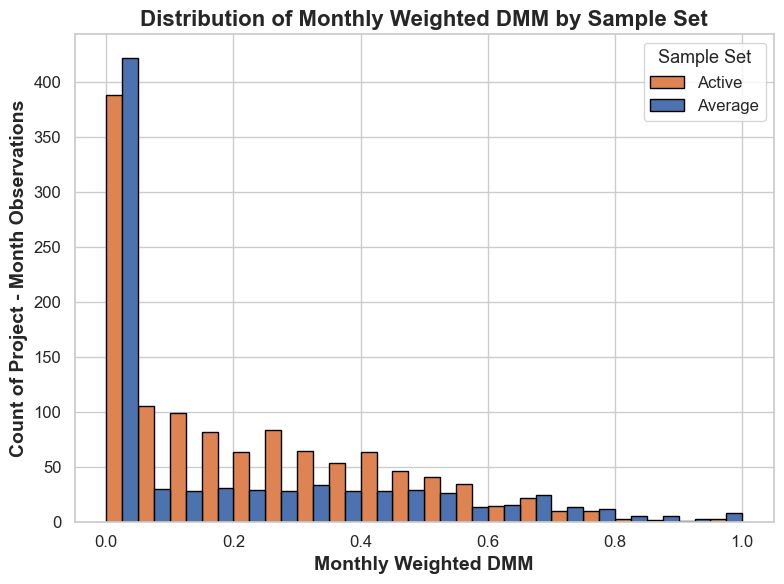

In [3]:
active  = pd.read_csv('dmm_active.csv',  parse_dates=['month'])
average = pd.read_csv('dmm_average.csv', parse_dates=['month'])

a_vals = active ['dmm_monthly_w'].dropna()
v_vals = average['dmm_monthly_w'].dropna()

n_bins = 20
bins = np.linspace(0, 1, n_bins + 1)

a_counts, _ = np.histogram(a_vals, bins=bins)
v_counts, _ = np.histogram(v_vals, bins=bins)

sns.set_theme(style="whitegrid")
fig, ax = plt.subplots(figsize=(8,6))

width = (bins[1] - bins[0]) * 0.5
ax.bar(bins[:-1]       , a_counts, width=width, align='edge',
       color='C1', edgecolor='black', label='Active')
ax.bar(bins[:-1] + width, v_counts, width=width, align='edge',
       color='C0', edgecolor='black', label='Average')

ax.set_title('Distribution of Monthly Weighted DMM by Sample Set', fontsize=16, fontweight='bold')
ax.set_xlabel('Monthly Weighted DMM', fontsize=14, fontweight='bold')
ax.set_ylabel('Count of Project - Month Observations', fontsize=14, fontweight='bold')
ax.tick_params(labelsize=12)
ax.legend(title='Sample Set', fontsize=12, title_fontsize=13, loc='upper right')

plt.tight_layout()
plt.show()


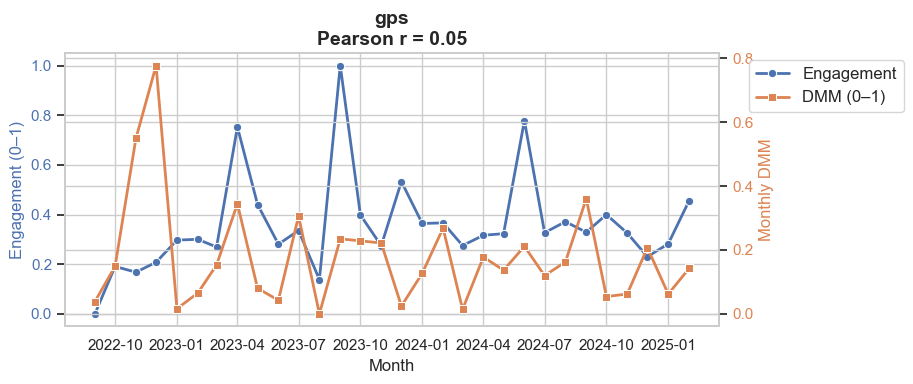

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr

eng = pd.read_csv('engagement_score_active.csv', parse_dates=['month'])
dmm = pd.read_csv('dmm_active.csv',               parse_dates=['month'])

df = (
    pd.merge(
        eng[['url','month','engagement_score']],
        dmm[['url','month','dmm_monthly_w']],
        on=['url','month'],
        how='inner'
    )
    .dropna()
)

sns.set_theme(style="whitegrid")

for repo in df['url'].unique():
    proj = df[df['url']==repo].sort_values('month')
    if len(proj) < 2:
        continue

    r, _ = pearsonr(proj['engagement_score'], proj['dmm_monthly_w'])

    fig, ax = plt.subplots(figsize=(8,4))
    ax2 = ax.twinx()

    l1 = sns.lineplot(
        x='month', y='engagement_score',
        data=proj,
        marker='o', linewidth=2, color='C0',
        legend=False,
        ax=ax
    )
    ax.set_ylabel('Engagement (0–1)', color='C0', fontsize=12)
    ax.tick_params(axis='y', labelcolor='C0')

    l2 = sns.lineplot(
        x='month', y='dmm_monthly_w',
        data=proj,
        marker='s', linewidth=2, color='C1',
        legend=False,
        ax=ax2
    )
    ax2.set_ylabel('Monthly DMM', color='C1', fontsize=12)
    ax2.tick_params(axis='y', labelcolor='C1')

    name = repo.rsplit('/',1)[-1]
    ax.set_title(f"{name}\nPearson r = {r:.2f}", fontsize=14, fontweight='bold')
    ax.set_xlabel('Month', fontsize=12)

    line1 = ax.lines[0]
    line2 = ax2.lines[0]
    fig.legend(
        handles=[line1, line2],
        labels=['Engagement', 'DMM (0–1)'],
        loc='upper right',
        bbox_to_anchor=(1.15, 0.85),
        frameon=True,
        fontsize=12
    )

    fig.subplots_adjust(right=0.80)

    plt.tight_layout()
    plt.show()
    break # comment this line to view all the projects
